In [1]:
import pandas as pd
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import tensorflow as tf
tf.get_logger().setLevel("ERROR")


# Charger le CSV
df = pd.read_csv("../data/dataset_selection_non_zoomer.csv")

# Aperçu du dataset
print("Aperçu du dataset :")
print(df.head())

print("\nInformations générales :")
print(df.info())


Aperçu du dataset :
                                                path     label
0  /home/mathis/Memoire/data/glaucome/DRISHTI-GS/...  glaucome
1  /home/mathis/Memoire/data/glaucome/DRISHTI-GS/...  glaucome
2  /home/mathis/Memoire/data/glaucome/DRISHTI-GS/...  glaucome
3  /home/mathis/Memoire/data/glaucome/DRISHTI-GS/...  glaucome
4  /home/mathis/Memoire/data/glaucome/DRISHTI-GS/...  glaucome

Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6637 entries, 0 to 6636
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    6637 non-null   object
 1   label   6637 non-null   object
dtypes: object(2)
memory usage: 103.8+ KB
None


In [2]:
print(f"Nombre total d'images : {len(df)}")
print(f"Nombre de colonnes : {df.shape[1]}")


Nombre total d'images : 6637
Nombre de colonnes : 2


In [3]:
# Compter le nombre d'images par label
class_counts = df['label'].value_counts()

print("\nRépartition des labels :")
print(class_counts)

# Pourcentage par label
class_percent = df['label'].value_counts(normalize=True) * 100
print("\nPourcentage par label :")
print(class_percent.round(2))



Répartition des labels :
label
normaux     1997
glaucome    1949
mda         1632
diabete     1059
Name: count, dtype: int64

Pourcentage par label :
label
normaux     30.09
glaucome    29.37
mda         24.59
diabete     15.96
Name: proportion, dtype: float64


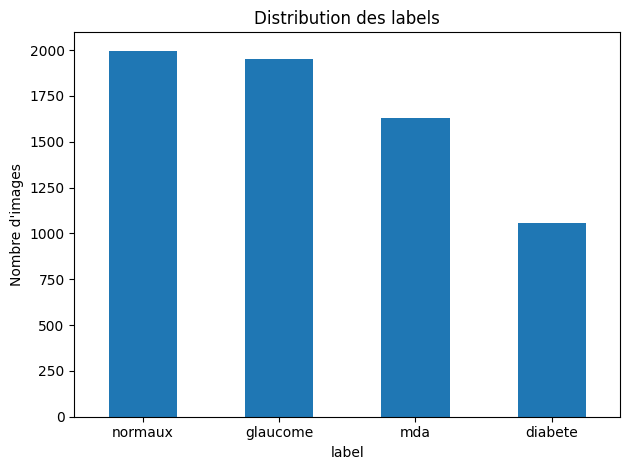

In [4]:
import matplotlib.pyplot as plt

class_counts.plot(kind='bar')
plt.title("Distribution des labels")
plt.xlabel("label")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [5]:
for classe in df['label'].unique():
    print(f"\nExemples pour la classe '{classe}' :")
    print(df[df['label'] == classe]['path'].head(3).tolist())



Exemples pour la classe 'glaucome' :
['/home/mathis/Memoire/data/glaucome/DRISHTI-GS/DRISHTI-GS/Training/glaucoma/drishtiGS_064.png', '/home/mathis/Memoire/data/glaucome/DRISHTI-GS/DRISHTI-GS/Training/glaucoma/drishtiGS_084.png', '/home/mathis/Memoire/data/glaucome/DRISHTI-GS/DRISHTI-GS/Training/glaucoma/drishtiGS_058.png']

Exemples pour la classe 'mda' :
['/home/mathis/Memoire/data/mda/AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection/AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection/AMDNet23 Dataset/train/amd/235_left.jpg', '/home/mathis/Memoire/data/mda/AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection/AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection/AMDNet23 Dataset/train/amd/1202_right.jpg', '/home/mathis/Memoire/data/mda/AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection/AMDNet23 Fundus Image Dataset 

In [6]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df,
    test_size=0.3,
    stratify=df['label'],
    random_state=42
)

df_test, df_val = train_test_split(
    df_test,
    test_size=0.5,
    stratify=df_test['label'],
    random_state=42
)




print("Tailles des splits :")
print(f"Train : {len(df_train)}")
print(f"Test : {len(df_test)}")
print(f"Validation : {len(df_val)}")

Tailles des splits :
Train : 4645
Test : 996
Validation : 996


In [7]:
def show_distribution(name, data):
    print(f"\n{name}")
    print(data['label'].value_counts(normalize=True).round(3))

show_distribution("Train", df_train)
show_distribution("Test", df_test)
show_distribution("Validation", df_val)



Train
label
normaux     0.301
glaucome    0.294
mda         0.246
diabete     0.160
Name: proportion, dtype: float64

Test
label
normaux     0.301
glaucome    0.293
mda         0.246
diabete     0.160
Name: proportion, dtype: float64

Validation
label
normaux     0.300
glaucome    0.294
mda         0.246
diabete     0.160
Name: proportion, dtype: float64


In [8]:
import sys, torch
print(sys.executable)
print(torch.__version__)
import torch
print(torch.__version__)
print("cuda available:", torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

x = torch.randn(1000, 1000, device="cuda")
print("OK:", x.mean().item())


/home/mathis/Memoire/.venv/bin/python
2.5.1+cu121
2.5.1+cu121
cuda available: True
NVIDIA GeForce RTX 3070 Ti
OK: -0.0007919682539068162


In [10]:
# =========================
# PyTorch pipeline COMPLET (ResNet34 pré-entraîné + class weights + AMP + AdamW + ReduceLROnPlateau + EarlyStopping)
# =========================

import os, numpy as np
from collections import Counter
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler

IMG = 224
BATCH = 32
EPOCHS = 300
PATIENCE = 10
NUM_WORKERS = 2

# -------------------------------------------------
# 0) Device
# -------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------------------------------
# 1) Transforms (ImageNet)
# -------------------------------------------------
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

eval_tfms = transforms.Compose([
    transforms.Resize(IMG+32),
    transforms.CenterCrop(IMG),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# -------------------------------------------------
# 2) Dataset depuis DataFrame splits: df_train/df_val/df_test
#    df_* doit contenir colonnes: "path" et "label"
# -------------------------------------------------
class FromSamples(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = np.array(paths)
        self.labels = np.array(labels)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, int(self.labels[i])

# --- Vérif colonnes ---
for name, d in [("df_train", df_train), ("df_val", df_val), ("df_test", df_test)]:
    assert "path" in d.columns and "label" in d.columns, f"{name} doit avoir colonnes 'path' et 'label'"

# --- Remap labels -> {0..C-1} (IMPORTANT pour CrossEntropyLoss) ---
orig_classes = sorted(df_train["label"].unique().tolist())
label_map = {c: i for i, c in enumerate(orig_classes)}
print("Label mapping:", label_map)

df_train = df_train.copy()
df_val   = df_val.copy()
df_test  = df_test.copy()

df_train["label"] = df_train["label"].map(label_map)
df_val["label"]   = df_val["label"].map(label_map)
df_test["label"]  = df_test["label"].map(label_map)

# --- Datasets ---
ds_train = FromSamples(df_train["path"].values, df_train["label"].values, train_tfms)
ds_val   = FromSamples(df_val["path"].values,   df_val["label"].values,   eval_tfms)
ds_test  = FromSamples(df_test["path"].values,  df_test["label"].values,  eval_tfms)

train_loader = DataLoader(ds_train, batch_size=BATCH, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(ds_val,   batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(ds_test,  batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# -------------------------------------------------
# 3) Class weights (robuste, sans division par zéro)
# -------------------------------------------------
cnt = Counter(df_train["label"].values.tolist())
num_classes = len(orig_classes)

print("Train counts:", cnt)
if len(cnt) != num_classes:
    print("⚠️ Attention: une ou plusieurs classes sont absentes du train. "
          "Impossible de calculer des poids pour une classe absente. "
          "On calcule quand même des poids, mais ton split est à revoir.")

# On construit un vecteur de taille num_classes, avec fallback si cnt[c]==0
weights_list = []
for c in range(num_classes):
    if cnt.get(c, 0) == 0:
        # fallback: poids = 1.0 (tu peux aussi mettre très grand, mais ça casse souvent l'entraînement)
        weights_list.append(1.0)
    else:
        weights_list.append(len(df_train) / (num_classes * cnt[c]))

weights_ce = torch.tensor(weights_list, dtype=torch.float32, device=device)
print("Class weights:", weights_ce.tolist())

# -------------------------------------------------
# 4) Modèle: ResNet34 pré-entraîné ImageNet + tête 2 classes (ou num_classes)
# -------------------------------------------------
weights = models.ResNet34_Weights.IMAGENET1K_V1
model = models.resnet34(weights=weights)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=weights_ce)
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, verbose=True)
scaler = GradScaler()

# -------------------------------------------------
# 5) Eval / Train loops + Early stopping
# -------------------------------------------------
@torch.no_grad()
def evaluate(loader):
    model.eval()
    loss_sum, correct, n = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        with autocast():
            logits = model(x)
            loss = criterion(logits, y)
        loss_sum += loss.item() * x.size(0)
        correct  += (logits.argmax(1) == y).sum().item()
        n += x.size(0)
    return loss_sum / max(n, 1), correct / max(n, 1)

best_acc, best_state = 0.0, None
wait = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    run_loss, n = 0.0, 0

    for x, y in train_loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with autocast():
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        run_loss += loss.item() * x.size(0)
        n += x.size(0)

    train_loss = run_loss / max(n, 1)
    val_loss, val_acc = evaluate(val_loader)
    scheduler.step(val_loss)

    print(f"Epoch {epoch:03d} | train_loss {train_loss:.4f} | val_loss {val_loss:.4f} | val_acc {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        wait = 0
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping.")
            break


Device: cuda
Label mapping: {0: 0, 1: 1, 2: 2, 3: 3}
Train counts: Counter({3: 1398, 1: 1364, 2: 1142, 0: 741})
Class weights: [1.5671390295028687, 0.8513563275337219, 1.0168564319610596, 0.8306509256362915]


/tmp/ipykernel_1297/4163071048.py:129: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_1297/4163071048.py:159: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_1297/4163071048.py:140: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 001 | train_loss 0.6231 | val_loss 0.7509 | val_acc 0.7590
Epoch 002 | train_loss 0.4653 | val_loss 0.7249 | val_acc 0.7490
Epoch 003 | train_loss 0.4046 | val_loss 0.9202 | val_acc 0.7550
Epoch 004 | train_loss 0.3714 | val_loss 0.7035 | val_acc 0.7731
Epoch 005 | train_loss 0.3437 | val_loss 0.9179 | val_acc 0.7661
Epoch 006 | train_loss 0.3272 | val_loss 0.7439 | val_acc 0.7731
Epoch 007 | train_loss 0.3002 | val_loss 0.8652 | val_acc 0.7711
Epoch 008 | train_loss 0.2474 | val_loss 0.9176 | val_acc 0.7831
Epoch 009 | train_loss 0.2286 | val_loss 0.9404 | val_acc 0.7701
Epoch 010 | train_loss 0.2121 | val_loss 0.9755 | val_acc 0.7821
Epoch 011 | train_loss 0.1759 | val_loss 0.7601 | val_acc 0.8032
Epoch 012 | train_loss 0.1574 | val_loss 1.0355 | val_acc 0.7902
Epoch 013 | train_loss 0.1456 | val_loss 1.0718 | val_acc 0.7761
Epoch 014 | train_loss 0.1268 | val_loss 1.0742 | val_acc 0.7892
Epoch 015 | train_loss 0.1217 | val_loss 0.9987 | val_acc 0.8022
Epoch 016 | train_loss 0.


=== Scores globaux ===
Accuracy            : 0.7628
Balanced accuracy   : 0.7637
Precision (macro)   : 0.7616
Recall (macro)      : 0.7637
F1 (macro)          : 0.7381
Precision (weighted): 0.7613
Recall (weighted)   : 0.7628
F1 (weighted)       : 0.7374

=== Rapport par classe ===
              precision    recall  f1-score   support

     diabete       0.66      0.96      0.78       300
    glaucome       0.85      0.97      0.90       292
         mda       0.86      0.81      0.84       302
     normaux       0.68      0.31      0.43       299

    accuracy                           0.76      1193
   macro avg       0.76      0.76      0.74      1193
weighted avg       0.76      0.76      0.74      1193



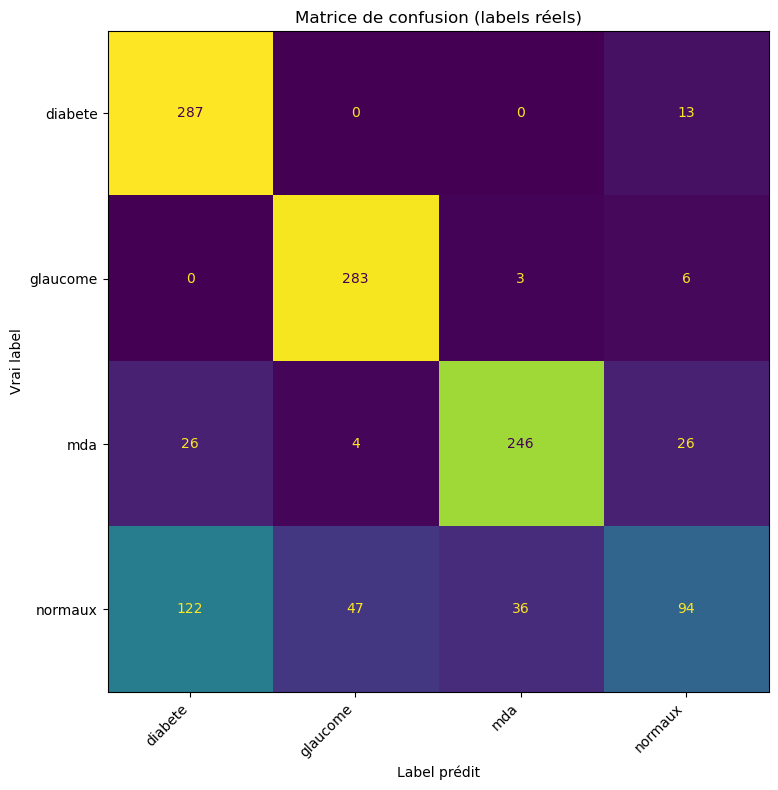

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    balanced_accuracy_score,
    classification_report
)
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

proba = model.predict(test_ds, verbose=0)
y_pred = np.argmax(proba, axis=1)
num_classes = len(classes)

# ----------------------------
# 7) METRICS
# ----------------------------
acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)

prec_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
rec_macro  = recall_score(y_true, y_pred, average="macro", zero_division=0)
f1_macro   = f1_score(y_true, y_pred, average="macro", zero_division=0)

prec_weighted = precision_score(y_true, y_pred, average="weighted", zero_division=0)
rec_weighted  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1_weighted   = f1_score(y_true, y_pred, average="weighted", zero_division=0)

print("\n=== Scores globaux ===")
print(f"Accuracy            : {acc:.4f}")
print(f"Balanced accuracy   : {bacc:.4f}")
print(f"Precision (macro)   : {prec_macro:.4f}")
print(f"Recall (macro)      : {rec_macro:.4f}")
print(f"F1 (macro)          : {f1_macro:.4f}")
print(f"Precision (weighted): {prec_weighted:.4f}")
print(f"Recall (weighted)   : {rec_weighted:.4f}")
print(f"F1 (weighted)       : {f1_weighted:.4f}")

print("\n=== Rapport par classe ===")
print(classification_report(y_true, y_pred, target_names=classes, zero_division=0))

# ----------------------------
# 8) CONFUSION MATRIX (labels réels, ordre forcé)
# ----------------------------
label_indices = list(range(num_classes))
cm = confusion_matrix(y_true, y_pred, labels=label_indices)

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax, values_format="d", cmap=None, colorbar=False)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.xlabel("Label prédit")
plt.ylabel("Vrai label")
plt.title("Matrice de confusion (labels réels)")
plt.tight_layout()
plt.show()


Nombre d'images mal classées : 283


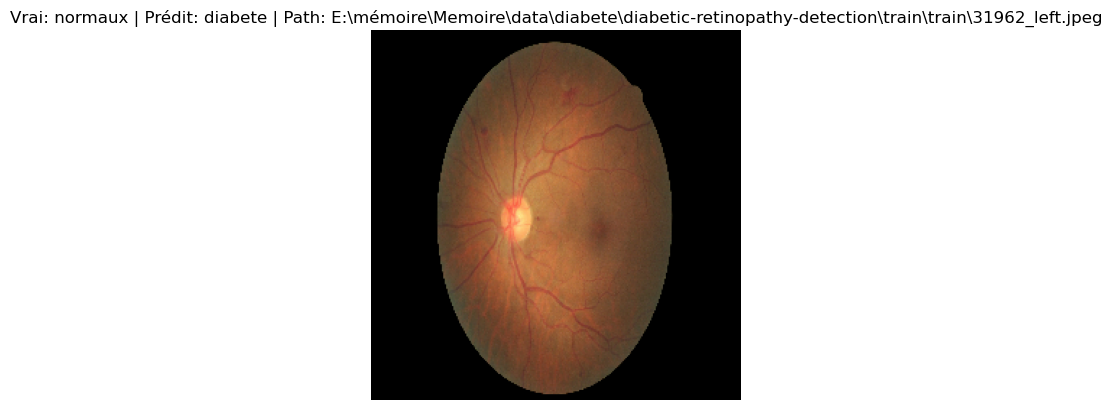

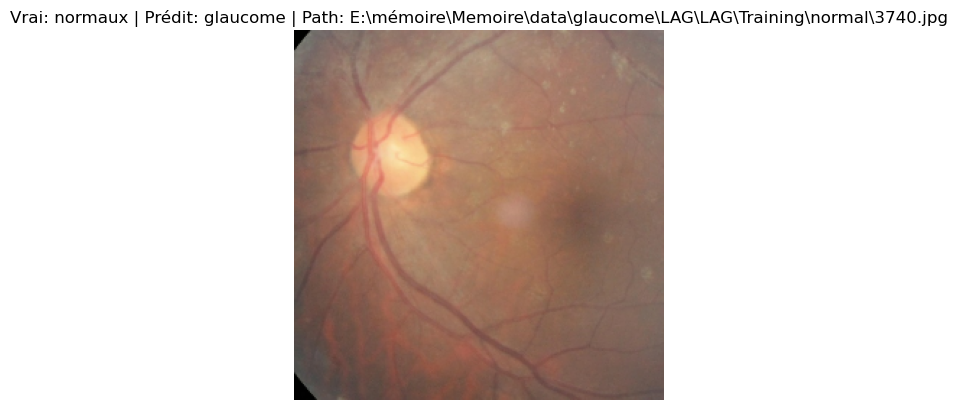

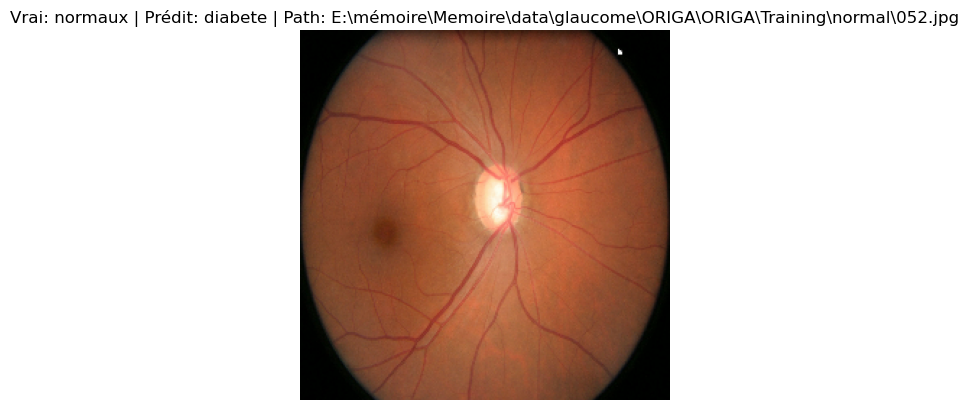

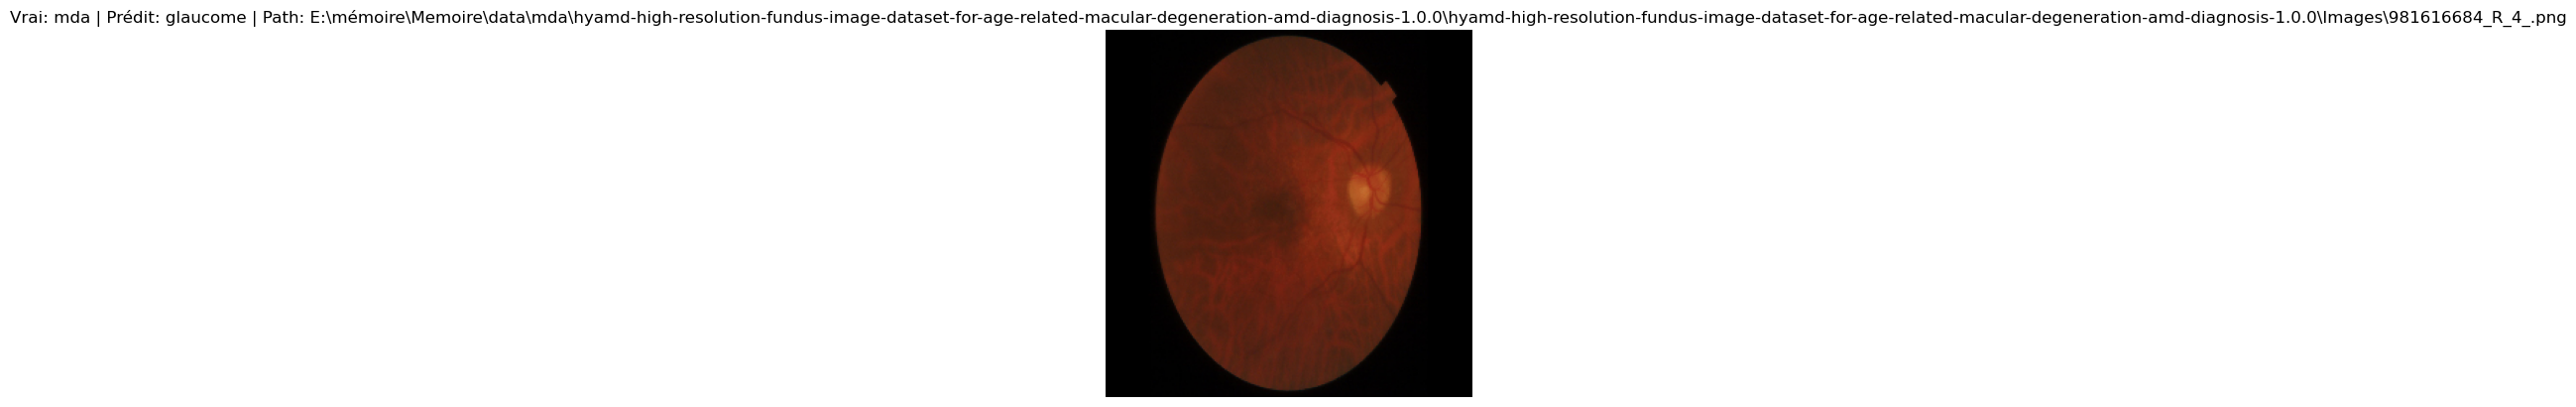

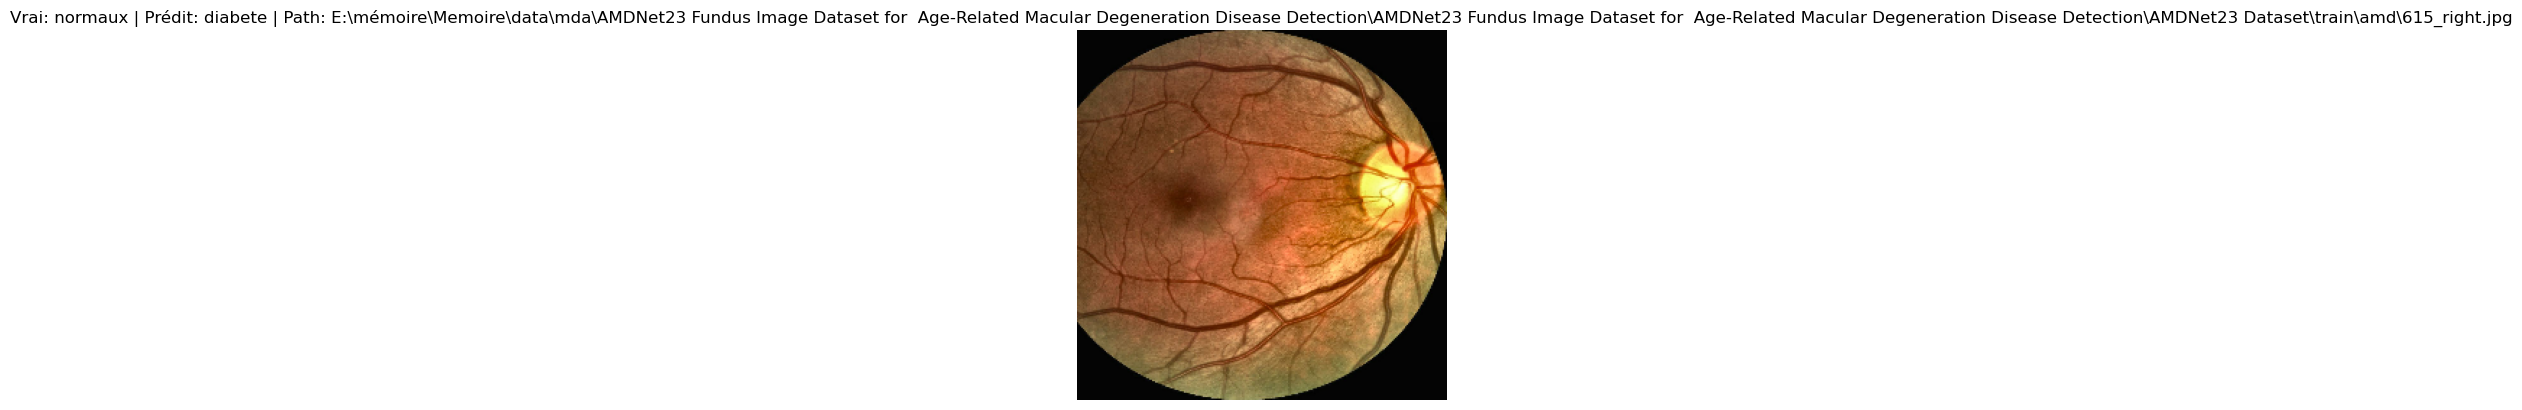

In [ ]:
#montre des exemples d'images mal classées
import numpy as np
misclassified_indices = np.where(y_true != y_pred)[0]
print(f"Nombre d'images mal classées : {len(misclassified_indices)}")   
for idx in misclassified_indices[:5]:  # Affiche les 5 premières erreurs
    img_path = df_test.iloc[idx]['path']
    true_label = classes[y_true[idx]]
    pred_label = classes[y_pred[idx]]

    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)

    plt.imshow(img.numpy().astype("uint8"))
    plt.title(f"Vrai: {true_label} | Prédit: {pred_label} | Path: {img_path}")
    plt.axis("off")
    plt.show()